In [1]:
# confirm Keras sees the GPU
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

Using TensorFlow backend.


In [2]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from stark.conv.fcheadnet import FCHeadNet
from stark.datasets.dataloader import DataLoader
from stark.processing.imagetoarray import ImageToArray
from stark.processing.aspectaware import AspectAware
from stark.conv.minivggnet import MiniVGGNet
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.applications import VGG16
from keras.layers import Input
from keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from imutils import paths
import numpy as np
import argparse
import os

Text(0.5, 1.0, 'Melanoma image with dimensions (224, 224, 3)')

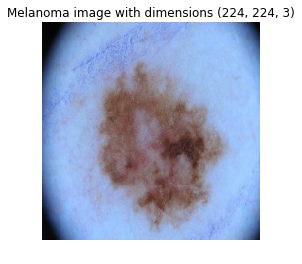

In [3]:
%matplotlib inline
import matplotlib.image as mpimg
img = mpimg.imread('new_data/train/melanoma/ISIC_0000002.jpg')
plt.imshow(img)
plt.axis('off')
plt.title('Melanoma image with dimensions {}'.format(img.shape))

In [6]:
# define path to output model
output_model_dir = 'output_model/'
# define paths to datasets
train_path = 'new_data/train/'
val_path = 'new_data/valid/'
test_path = 'new_data/test/'


# create extra function to load data
def load_data_master(data_path):
    # grab the list of images that we’ll be describing, then extract
    # the class label names from the image paths
    print("[INFO] loading images...")
    image_paths = list(paths.list_images(data_path))
    class_names = [pt.split(os.path.sep)[-2] for pt in image_paths]
    class_names = [str(x) for x in np.unique(class_names)]
    # load the dataset from disk then scale the raw pixel intensities to
    # the range [0, 1]
    # initialize the image preprocessors
    #aa = AspectAware(224, 224)
    ia = ImageToArray()
    dl = DataLoader(preprocessors=[ia])
    (data, labels) = dl.load(image_paths, verbose=500)
    data = data.astype("float") / 255.0
    return data, labels


In [7]:
trainX, trainY = load_data_master(train_path)
valX, valY = load_data_master(val_path)
testX, testY = load_data_master(test_path)

[INFO] loading images...
[info] processed 500/4500
[info] processed 1000/4500
[info] processed 1500/4500
[info] processed 2000/4500
[info] processed 2500/4500
[info] processed 3000/4500
[info] processed 3500/4500
[info] processed 4000/4500
[info] processed 4500/4500
[INFO] loading images...
[INFO] loading images...
[info] processed 500/1200
[info] processed 1000/1200


In [8]:
print('Dimensions of the output training set', trainY.shape)
unique, counts = np.unique(trainY, return_counts=True)
dictionary = dict(zip(unique, counts))
print(dictionary)

Dimensions of the output training set (4500,)
{'melanoma': 1500, 'nevus': 1500, 'seborrheic_keratosis': 1500}


In [9]:
def data_explore_labels(data, color='r', title='Classes Distribution'):
    unique, counts = np.unique(data, return_counts=True)
    dictionary = dict(zip(unique, counts))
    counts = pd.DataFrame(columns=['label','quantity'],data=[(label, count) for label,
                                                             count in dictionary.items()])
    plt.figure(figsize=(9,9))
    sns.set(font_scale=1.5)
    sns.barplot(x='quantity',y='label',data=counts,orient='o', color=color)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.ylabel('Labels')
    plt.xlabel('Quantity');
    plt.tight_layout()

Distribution of training data


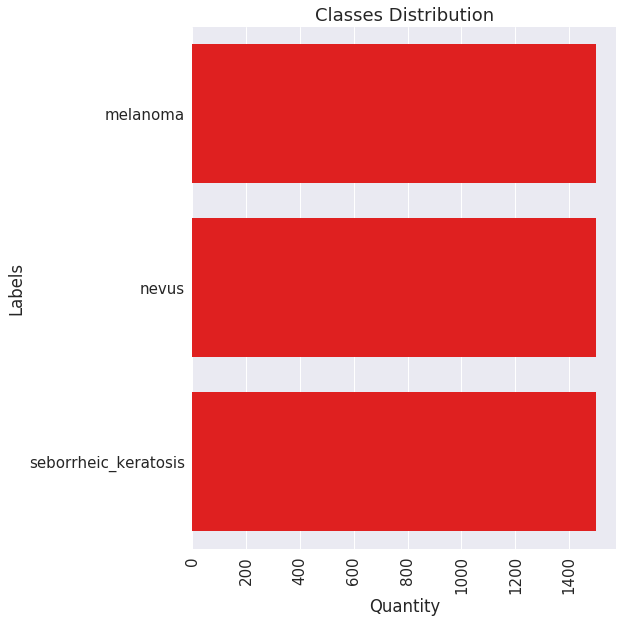

In [10]:
print('Distribution of training data')
data_explore_labels(trainY, 'r')

Distribution of validation data


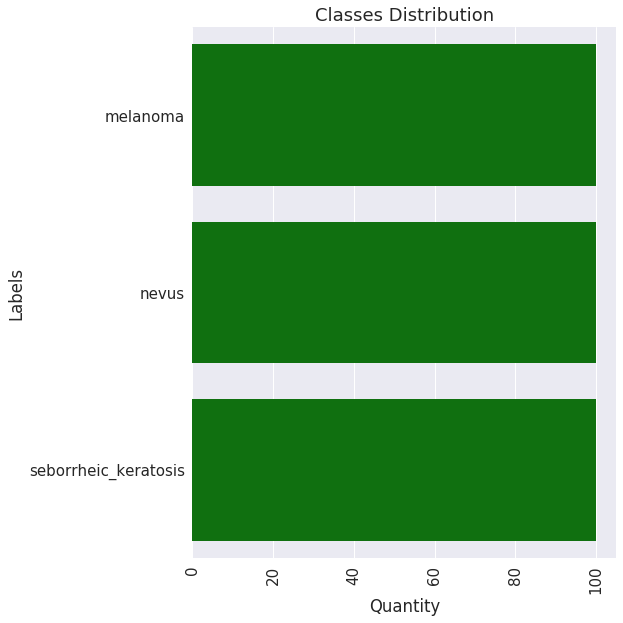

In [11]:
print('Distribution of validation data')
data_explore_labels(valY, 'g')

Distribution of test data


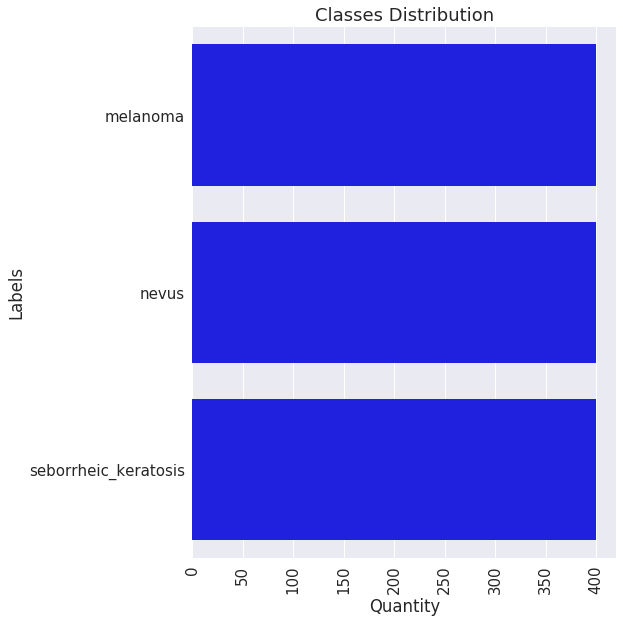

In [12]:
print('Distribution of test data')
data_explore_labels(testY, 'b')

In [13]:
# convert output labels to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
valY = lb.fit_transform(valY)
testY = lb.fit_transform(testY)

In [14]:
model = MiniVGGNet.build(width=224, height=224, depth=3, classes=len(lb.classes_))

In [15]:
print('[info] compiling model ...')
optimizer = RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
              metrics=['accuracy'])

[info] compiling model ...


In [16]:
print("[INFO] training head...")
epochs = 10
bs = 32
H = model.fit(trainX, trainY,
          batch_size=bs,
          epochs=epochs,
          verbose=1,
          validation_data=(valX, valY))

[INFO] training head...
Train on 4500 samples, validate on 300 samples
Epoch 1/10
4500/4500 [==============================] - 40s 9ms/step - loss: 1.3509 - acc: 0.5664 - val_loss: 3.8589 - val_acc: 0.4767
Epoch 2/10
4500/4500 [==============================] - 29s 6ms/step - loss: 0.9870 - acc: 0.6182 - val_loss: 2.8067 - val_acc: 0.3900
Epoch 3/10
4500/4500 [==============================] - 28s 6ms/step - loss: 0.8370 - acc: 0.6713 - val_loss: 1.2510 - val_acc: 0.5833
Epoch 4/10
4500/4500 [==============================] - 28s 6ms/step - loss: 0.7535 - acc: 0.6967 - val_loss: 2.0172 - val_acc: 0.4767
Epoch 5/10
4500/4500 [==============================] - 29s 6ms/step - loss: 0.6803 - acc: 0.7264 - val_loss: 1.6565 - val_acc: 0.5200
Epoch 6/10
4500/4500 [==============================] - 29s 6ms/step - loss: 0.6317 - acc: 0.7509 - val_loss: 1.1513 - val_acc: 0.5500
Epoch 7/10
4500/4500 [==============================] - 29s 6ms/step - loss: 0.5820 - acc: 0.7676 - val_loss: 1.2688 - 

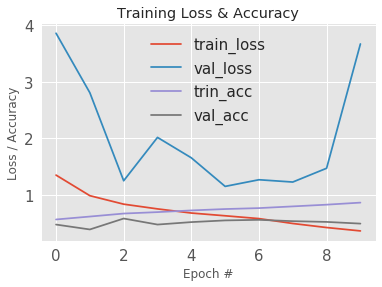

In [17]:
# plot learning curves
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, epochs), H.history['acc'], label='trin_acc')
plt.plot(np.arange(0, epochs), H.history['val_acc'], label='val_acc')
plt.title('Training Loss & Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

In [18]:
# evaluate the network on the fine-tuned model
print("[INFO] evaluating after fine-tuning...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating after fine-tuning...
                      precision    recall  f1-score   support

            melanoma       0.44      0.69      0.54       400
               nevus       0.66      0.91      0.76       400
seborrheic_keratosis       0.22      0.01      0.02       400

         avg / total       0.44      0.54      0.44      1200

